In [1]:
import wpy as hp
import os
import pandas as pd

In [2]:
# parameters
model_name = 'S_CCBT_X'
cust_id_column_name = 'GCIS_KEY'
build_month = '201902'
modeller = 'Francis'
num_features_to_keep = 100

In [3]:
# TD cohort table for modelling
td_model_cohort_table = "C4USTPMK.S_CCBT_X_cohort"
# TD table containing socring population: cust id and data_dt
td_score_population_name = "C4USTPMK.s_ccbt_x_score_population"
# feature table to be created for scoring
td_score_table_name = "C4USTPMK.S_CCBT_X_score_population_features"
# sql script to create the above "td_score_table_name"
score_sql_file_name = "scoring_population.sql"

In [4]:
cnxn = hp.connect_td(os.environ['TDPASS'])
query = 'sel * from {{COHORT_TABLE}}'.replace("{{COHORT_TABLE}}", td_model_cohort_table)
data = pd.read_sql(query, cnxn)
data = hp.col_upper_case(data)

target = hp.get_single_column(data, 'TARGET_F')

In [5]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
                     ('Var Dropper', hp.VarDropper()),
                     ('Imputer', hp.Imputer()),
                     ('Encoder', hp.Encoder())])

In [6]:
# feature reduction
df = pipeline.transform(data)

In [7]:
# split train / test
from sklearn.model_selection import train_test_split
features = df.columns
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3)

In [8]:
import xgboost as xgb
model = xgb.XGBClassifier().fit(X_train, y_train)

In [9]:
top_features = hp.get_var_importance(model, features, num_features_to_keep)

In [10]:
# finalize model
dfx = pipeline.transform(data[list(top_features.index)])
# features_final = dfx.columns
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(dfx, target, test_size=0.3)

In [11]:
model_final = xgb.XGBClassifier().fit(X_train, y_train)
model_final.fit(X_train_final, y_train_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
# model vaidation
probas = model_final.predict_proba(X_test_final)
hp.print_model_performance(model_final, X_test_final, y_test_final)

Accuracy: 0.664263
Confustion Matrix: 
[[4269 2022]
 [2075 3837]]
AUC Score: 0.731547
GINI Coefficient: 0.463094


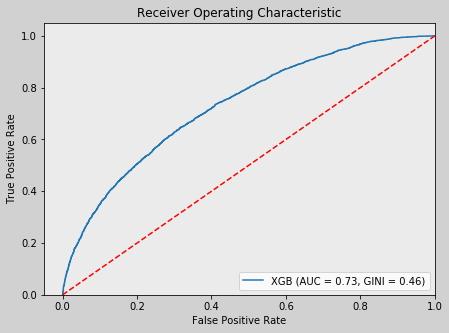

In [13]:
hp.plot_roc(model=model_final, model_label='XGB', X_test=X_test_final, y_test=y_test_final)

In [14]:
# store trained model
model_pack = hp.ModelWrapper(
        model=model_final, features=list(top_features.index), pipeline=pipeline, prob_train=0.5, prob_prior=0.5,
        algorithm='XGB', model_name=model_name, cust_key=[cust_id_column_name],
        version='1.0', build_month=build_month, built_by=modeller)

import pickle
model_file_name = model_name + '.pkl'
pickle.dump(model_pack, open(model_file_name, 'wb'))

In [15]:
hp.write_scoring_sql(top_features, td_score_population_name, td_score_table_name, score_sql_file_name)